# Sign Langage recognition on new dataset - Data Preparation

The goal of this notebook is too clean the dataset we've made ourselves. This involves a couple of steps :

* Removing images which are too similar
* Applying transformations on some images
* Split into train/test

Our data was gathered by taking videos of hands of 17 people that we later subsampled. This produced over 17,000 images.

## Librairies

In [1]:
# Libraries
import tensorflow as tf
import numpy as np
import pickle
from tqdm import tqdm
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
main_path = '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/'
data_path = main_path + "data/"
save_path = main_path + "FINAUX/saves/"
data_iterator = list(glob.glob(data_path + "*/*"))
data_length = len(data_iterator)

In [4]:
print('Loaded {} images for {}'.format(data_length, data_path))

Loaded 17131 images for /content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/data/


## Load and visualize the data

First we'll resize the images to be able to work on them more easily.

In [5]:
# Load and resize the images
reload_data = False
if reload_data:
  resizes_images = np.empty((data_length, 64, 64))
  images_mapping = {}
  for idx, filepath in tqdm(data_iterator):
    # Load image in grayscale
    im = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # Resize the image
    im = cv2.resize(im, (64, 64))
    # Save it
    resizes_images[idx] = im
    images_mapping[idx] = filepath
  # Dump everything
  np.save(save_path + "resized_images.npy", resizes_images)
  with open(save_path + "images_mapping.pkl", "wb") as f:
    pickle.dump(images_mapping, f)
else:
  # Load the numpy array
  resizes_images = np.load(save_path + "resized_images.npy")
  # Load the dictionnary
  with open(save_path + "images_mapping.pkl", "rb") as f:
    images_mapping = pickle.load(f)

Let's display a few of them

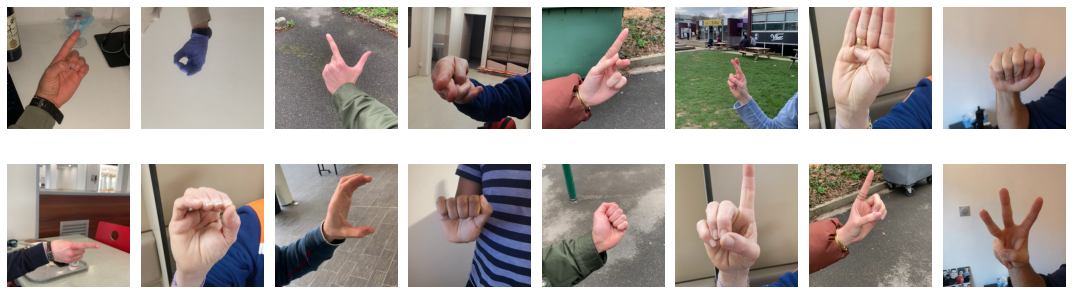

In [6]:
# Plot a few images
plt.figure(figsize=(15,5))
num_images = 16
indexes = np.random.randint(0, data_length, size=16)
for i in range(num_images):
  plt.subplot(2, 8, i+1)
  im = cv2.imread(images_mapping[indexes[i]])
  im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
  plt.imshow(im)
  plt.axis('off')
plt.tight_layout()
plt.show()

As you can see, there is a wide variety of images but there are 3 main problems :  

* Some images are very close from each other
* Some images are flipped or rotated
* Some hands can't be seen

## Recovering the prefixes and making statistics

Our dataset folder is written in the following manner: `letter_name/personname_lettername_frameidx.jpg` where `frameidx` is the number of the frame from the subsampled video. Let's group our data by (`personname`, `lettername`) we'll call that a prefix.

In [7]:
# Identify common prefix
from itertools import groupby
extract_prefix = lambda x : '_'.join(x.split('/')[-1].split('_')[:2])
extract_index = lambda x : int(x.split('/')[-1].split('_')[-1][:-4])
groups = {}
for key, group in groupby(sorted(data_iterator, key=extract_prefix), key=extract_prefix):
  # Extract the actual files
  groups[key] = list(map(lambda x : '/'.join(x.split('/')[-2:]), list(group)))
  # Sort them by index
  groups[key] = sorted(groups[key], key=extract_index)

Let's now plot distribution the length of the trajectories for each prefix.

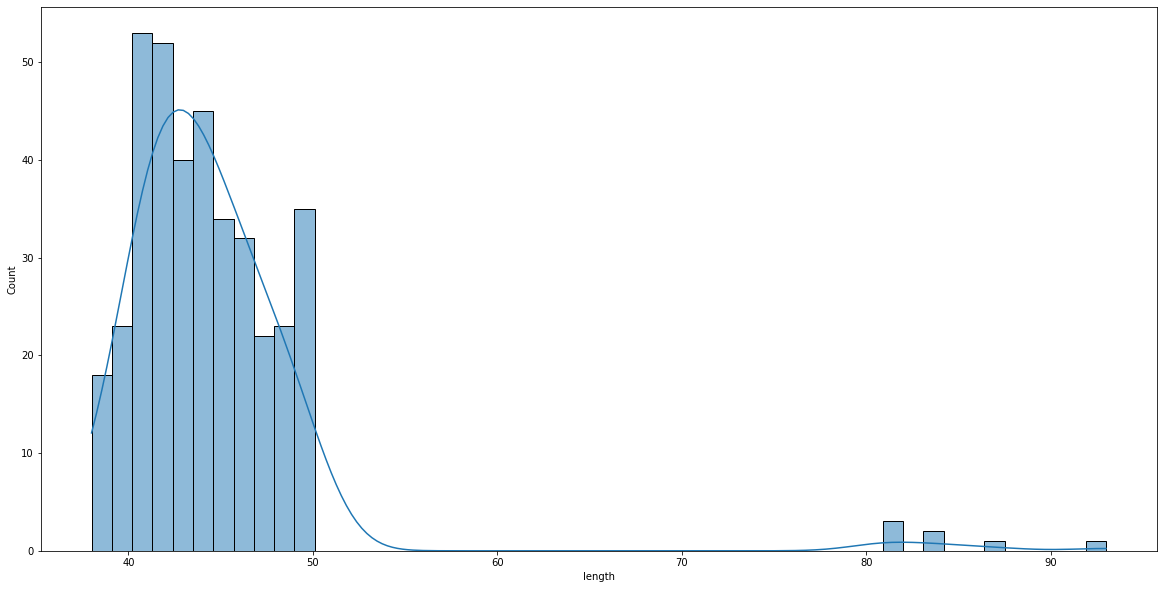

In [8]:
# Plot histogram of the lengths of the trajectories
trajetories_info = pd.DataFrame([{ 'prefix' : prefix, 'length' : len(group) } for prefix, group in groups.items()])
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(trajetories_info['length'], kde=True, ax=ax)

We can see that each prefix has an average of 43 images with a deviation of 5 images. Let's find what is the distance (in terms of RMSE) between the images of those sequence. The smaller is the RMSE, the closer are the images.

In [9]:
# Compute the reverse mapping
reversed_mapping = { v : k for k,v in images_mapping.items() }

In [10]:
# Compute sucessive RMSE for each image in each sequence
groups_rmse = {}
for prefix, group in tqdm(groups.items()):
  n = len(group)
  groups_rmse[prefix] = []
  for i in range(n-1):
    im1 = resizes_images[reversed_mapping[data_path + group[i]]]
    im2 = resizes_images[reversed_mapping[data_path + group[i+1]]]
    groups_rmse[prefix].append(np.sqrt(np.mean(np.square(im1 - im2))))

100%|██████████| 384/384 [00:00<00:00, 915.30it/s]


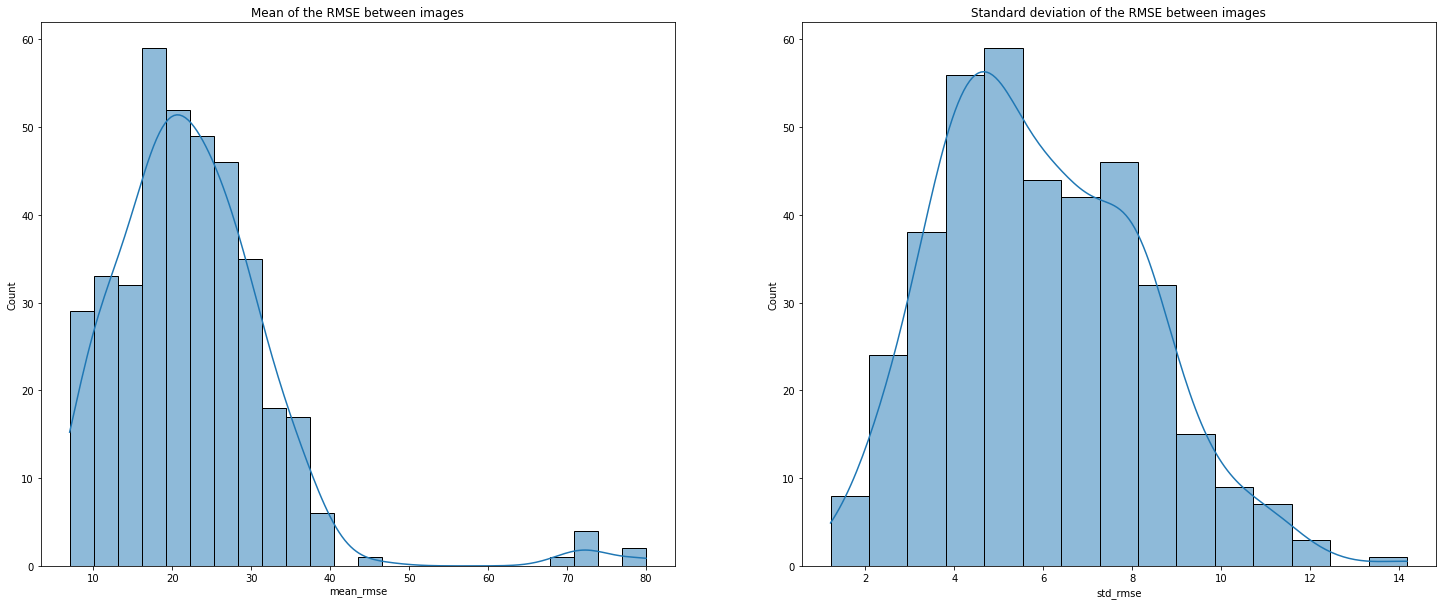

In [11]:
# Plot the RMSE between images

## Add to the dataframe
for prefix, rmses in groups_rmse.items():
  trajetories_info.loc[prefix, 'mean_rmse'] = np.mean(rmses)
  trajetories_info.loc[prefix, 'std_rmse'] = np.std(rmses)

## Plot the histogram for the mean
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(trajetories_info['mean_rmse'], kde=True)
plt.title("Mean of the RMSE between images")
plt.subplot(1, 2, 2)
sns.histplot(trajetories_info['std_rmse'], kde=True)
plt.title("Standard deviation of the RMSE between images")
plt.show()

We can see that the RMSE is very tiny.

## Thresholding out images based on RMSE

Because these "too similar" images could lead to overfitting or other problems of generalization in our network, we decide to remove some images by applying a threshold on the RMSE value:

In [12]:
# Now remove transitions lower than a given threshold
rmse_threshold = 35
groups_filtered = {}
for prefix, group in tqdm(groups.items()):
  n = len(group)
  # Take the middle of the sequence as the reference
  groups_filtered[prefix] = [group[int(n / 2)]]
  middle_img = resizes_images[reversed_mapping[data_path + group[int(n / 2)]]]
  # Forward pass
  cur_img = middle_img
  for i in range(int(n / 2) + 1, n):
    # Extract the next image
    tmp_img = resizes_images[reversed_mapping[data_path + group[i]]]
    # Compute the euclidian distance
    dist = np.sqrt(np.mean(np.square(cur_img - tmp_img)))
    # Conditionnaly append it
    if dist > rmse_threshold:
      groups_filtered[prefix].append(group[i])
      cur_img = tmp_img
  # Backward pass
  cur_img = middle_img
  for i in range(int(n / 2)-1, -1, -1):
    # Extract the next image
    tmp_img = resizes_images[reversed_mapping[data_path + group[i]]]
    # Compute the euclidian distance
    dist = np.sqrt(np.mean(np.square(cur_img - tmp_img)))
    # Conditionnaly append it
    if dist > rmse_threshold:
      groups_filtered[prefix].append(group[i])
      cur_img = tmp_img
  # Now sort the group again
  groups_filtered[prefix] = sorted(groups_filtered[prefix], key=extract_index)

100%|██████████| 384/384 [00:00<00:00, 878.00it/s]


We plot the new RMSEs :

100%|██████████| 384/384 [00:00<00:00, 3036.47it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


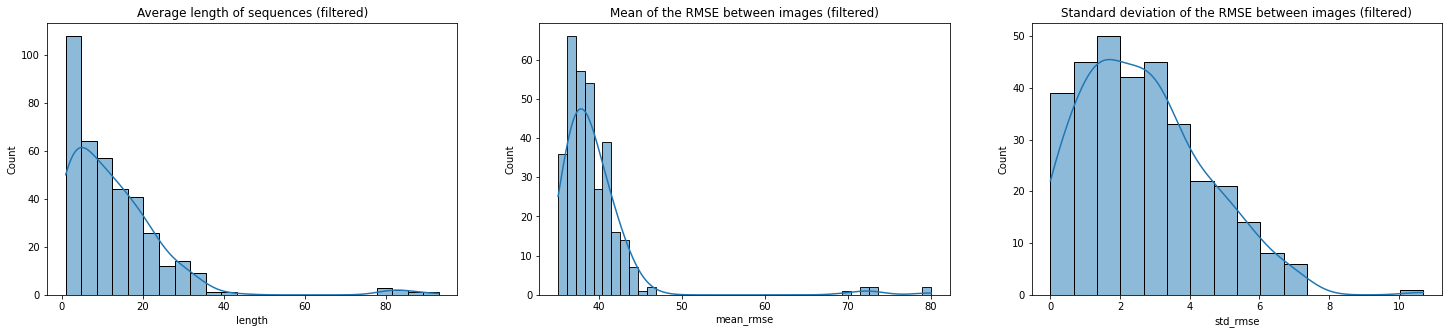

In [13]:
# Make new plots
trajetories_filtered_info = pd.DataFrame([{ 'prefix' : prefix, 'length' : len(group) } for prefix, group in groups_filtered.items()])

## Compute sucessive RMSE for each image in each sequence
groups_filtered_rmse = {}
for prefix, group in tqdm(groups_filtered.items()):
  n = len(group)
  groups_filtered_rmse[prefix] = []
  for i in range(n-1):
    im1 = resizes_images[reversed_mapping[data_path + group[i]]]
    im2 = resizes_images[reversed_mapping[data_path + group[i+1]]]
    groups_filtered_rmse[prefix].append(np.sqrt(np.mean(np.square(im1 - im2))))

## Add to the dataframe
for prefix, rmses in groups_filtered_rmse.items():
  trajetories_filtered_info.loc[prefix, 'mean_rmse'] = np.mean(rmses)
  trajetories_filtered_info.loc[prefix, 'std_rmse'] = np.std(rmses)

## Plot the histogram for the mean
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
sns.histplot(trajetories_filtered_info['length'], kde=True)
plt.title("Average length of sequences (filtered)")
plt.subplot(1, 3, 2)
sns.histplot(trajetories_filtered_info['mean_rmse'], kde=True)
plt.title("Mean of the RMSE between images (filtered)")
plt.subplot(1, 3, 3)
sns.histplot(trajetories_filtered_info['std_rmse'], kde=True)
plt.title("Standard deviation of the RMSE between images (filtered)")
plt.show()

In [14]:
# Number of images retained
n_previous = trajetories_info['length'].sum()
n_after = trajetories_filtered_info['length'].sum()
print("Kept only {} / {} = {}%".format(n_after, n_previous, round(n_after * 100 / n_previous, 2)))

Kept only 4874.0 / 17131.0 = 28.45%


We successfully filtered out 70% of the dataset.

## Fixing rotations and flipping

As we said previously, some images are not "ready" to be given to the network:

In [15]:
# Display all the different prefixes
plot_hands = False
if plot_hands:
  plt.figure(figsize=(150, 150), facecolor='white')
  group_idx = 1
  for prefix, group in tqdm(sorted(groups.items(), key=lambda x : (x[1][0][0], x[0]))):
    image_selected = group[int(len(group) / 2)]
    letter = image_selected[0]
    plt.subplot(20, 20, group_idx)
    im = cv2.imread(data_path + image_selected, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (256, 256))
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title("{} | {}".format(letter, prefix))
    group_idx += 1
  plt.savefig(save_path + 'hands.png')
else:
  # Read the hands image
  im = cv2.imread(save_path + 'hands.png', cv2.IMREAD_GRAYSCALE)
  # Show it
  plt.figure(figsize=(50, 50), facecolor='white')
  plt.imshow(im, cmap='gray')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

On this nice image of our dataset, we can see that many images are flipped and rotated. This will be the next thing to fix ! We created an Excel where we manually raised the issues of each prefix.

In [16]:
# Load the filled dataframe
df_operations = pd.read_excel('/'.join(save_path.split('/')[:-2]) + '/New data - operations.xlsx')
df_operations

,Unnamed: 0,letter,prefix,operation,comment
0,0.0,A,AAG_A,none,NaN
1,1.0,A,Célian Latex _A,flip,NaN
2,2.0,A,Célian_A,flip,NaN
3,3.0,A,Charles_A,none,NaN
4,4.0,A,Chong_A,flip,NaN
...,...,...,...,...,...
379,379.0,Y,Mamadou_Y,Suppr,NaN
380,380.0,Y,Maryline_Y,none,NaN
381,381.0,Y,Olivier_Y,none,NaN
382,382.0,Y,Taf taf_Y,flip,NaN


In [17]:
# Get the set of operations
set(df_operations['operation'])

{'Suppr', 'flip', 'none', 'pivot 180'}

Some images has to be deleted since we can't clearly see the hand, some are flipped, other are rotated by 180°.

In [18]:
# Make a dictionnary out of it 
operations_per_prefix = { prefix : op for prefix, op in zip(df_operations['prefix'], df_operations['operation'])}

We will apply those operations during the final dumping of the dataset

## Grouping the letters

Additionally, we noticed that our network had an hard time distinguishing the different letters. So we decided to group them according to their shape. This seemed logical to us since the person we asked to do letters in sign language are not expert and thus cannot really reproduce the subtleties between close letters.

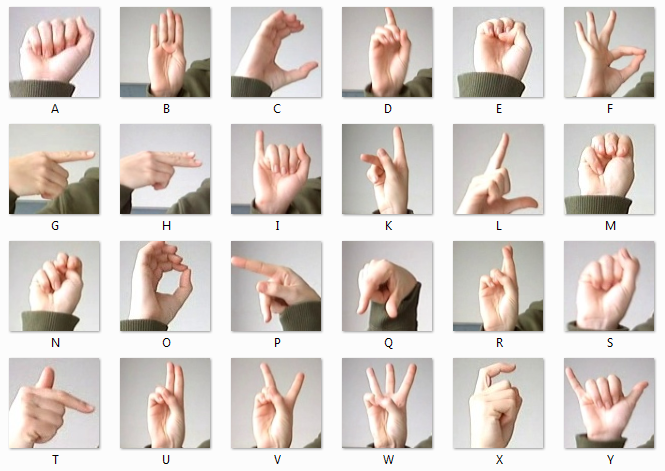

By hand, we see that A,E,I,M,N and S are kind of similar. Same for 


*   C, F and O,
*   D,K,R and U
*   G, H and T



In [19]:
# Group letters

## Build the groups
groups_letters = [
  'AEIMNS',
  'B',
  'COF',
  'DKRU',
  'GHT',
  'L',
  'P',
  'Q',
  'V',
  'W',
  'X',
  'Y'
]

## Make the mapping
mapping_letters = {}
for letter_group in groups_letters:
  for x in letter_group:
    mapping_letters[x] = letter_group

## Split between train and test

As we have a dataset composed of very similar images, the split between the training dataset and the test dataset is a real challenge. We decided to handle this problem with prefixes : for each letter, some prefixes will be stricly in the training dataset and some others will be in the test dataset. 

Note that one prefix could be in the training set of the letter A but in the testing set of the letter B.

In [20]:
# For each letter, do a prefix split
import random
letters_to_prefix = { l : [] for l in sorted(''.join(groups_letters)) }

# Extract the prefix
for prefix, g in groups.items():
  letters_to_prefix[g[0].split('/')[0]].append(prefix)

# Shuffle
for k in letters_to_prefix.keys():
  random.shuffle(letters_to_prefix[k])

# Assign a category to each prefix
prefix_category = {}
for letter, prefixes in letters_to_prefix.items():
  n = len(prefixes)
  train_end = int(0.85 * n)
  for prefix in prefixes[:train_end]:
    prefix_category[prefix] = 'train'
  for prefix in prefixes[train_end:]:
    prefix_category[prefix] = 'test'

## Final output

Let's first copy the data in the `/content/` folder for faster I/O.

In [21]:
# Copy the data
!cp -R "/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/data/" /content/

#### Data grouped

In [22]:
# Make the output folder
!mkdir -p data_new_grouped

In [23]:
# Create the dataset
import shutil
import os

# Build the folders
for letter_group in sorted(''.join(groups_letters)):
  for t in ['train','test']:
    directory = "data_new_grouped/{}/{}/".format(t, mapping_letters[letter_group])
    try:
      if not os.path.exists(directory):
        os.makedirs(directory)
    except OSError:
      print ('Error: Creating directory. ' +  directory)

## Browse everything
for prefix, group in tqdm(groups_filtered.items()):
  # Get the operation
  if prefix not in operations_per_prefix: continue
  op = operations_per_prefix[prefix]
  for f in group:
    letter, filename = f.split('/')
    src = 'data/' + f
    dst = 'data_new_grouped/{}/{}/{}'.format(prefix_category[prefix], mapping_letters[letter], filename)
    # Apply depending on operations
    if op == 'none':
      shutil.copyfile(src, dst)
    elif op == 'pivot 180':
      im = cv2.imread(src)
      im = cv2.rotate(im, cv2.ROTATE_180)
      cv2.imwrite(dst, im)
    elif op == 'flip':
      im = cv2.imread(src)
      im = cv2.flip(im, flipCode=1)
      cv2.imwrite(dst, im)

100%|██████████| 384/384 [00:09<00:00, 39.64it/s]


In [24]:
!find data_new_grouped/ -type f | wc -l
!ls data_new_grouped/train/
!find data_new_grouped/train/ -type f | wc -l
!find data_new_grouped/test/ -type f | wc -l

4431
AEIMNS	B  COF	DKRU  GHT  L  P  Q  V  W  X  Y
3713
718


#### Data not grouped

In [25]:
# Make the output folder
!mkdir -p data_new

In [26]:
# Create the dataset
import shutil
import os

# Build the folders
for letter_group in sorted(''.join(groups_letters)):
  for t in ['train','test']:
    directory = "data_new/{}/{}/".format(t, letter_group)
    try:
      if not os.path.exists(directory):
        os.makedirs(directory)
    except OSError:
      print ('Error: Creating directory. ' +  directory)

## Browse everything
for prefix, group in tqdm(groups_filtered.items()):
  # Get the operation
  if prefix not in operations_per_prefix: continue
  op = operations_per_prefix[prefix]
  for f in group:
    letter, filename = f.split('/')
    src = 'data/' + f
    dst = 'data_new/{}/{}/{}'.format(prefix_category[prefix], letter, filename)
    # Apply depending on operations
    if op == 'none':
      shutil.copyfile(src, dst)
    elif op == 'pivot 180':
      im = cv2.imread(src)
      im = cv2.rotate(im, cv2.ROTATE_180)
      cv2.imwrite(dst, im)
    elif op == 'flip':
      im = cv2.imread(src)
      im = cv2.flip(im, flipCode=1)
      cv2.imwrite(dst, im)

100%|██████████| 384/384 [00:09<00:00, 40.38it/s]


In [27]:
!find data_new/ -type f | wc -l
!ls data_new/train/
!find data_new/train/ -type f | wc -l
!find data_new/test/ -type f | wc -l

4431
A  B  C  D  E  F  G  H	I  K  L  M  N  O  P  Q	R  S  T  U  V  W  X  Y
3713
718
